In [1]:
!pip install pyldavis
!pip install torch
!pip install torchtext
!pip install sentence_transformers
!pip install langid
!pip install datasets
!pip install transformers
!pip install bertopic
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=ec8b3a88c01f90d14fb9f399c6da99f2a62e7afb22576165633431c0b4ba3443
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers
  Obtaining dependency information for bertopic from https://files.pythonhosted.org/packages/06/49/f395e2e4d21dd49803494c8aec6087db61ea0ba211c6e5e57540b23334eb/bertopic-0.15.0-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 57.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for cython<3,>=0.27 from https://files.pythonhosted.org/packages/f8/26/ca0f1bb049b83c

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
os.environ["TOKENIZERS_PARALLELISM"]="true"
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn
import gensim.corpora as corpora
import gensim
import string
import pyLDAvis
# import pyLDAvis.gensim_models
import langid
import random

from matplotlib import pyplot as plt
from pprint import pprint
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertModel, pipeline, get_linear_schedule_with_warmup
)
from datasets import Dataset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
from bertopic import BERTopic
from IPython.display import Image

torch.manual_seed(42)
torch.backends.cuda.deterministic = True

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/opt/conda/lib/python3.10/site-packages/tensorflow_probability/python/__init__.py:58: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  distutils.version.LooseVersion(required_tensorflow_version)):


# Agenda

1. [Load and Preprocess Data](#Load_and_Preprocess_Data)
2. [Clustering Algorithms](#Clustering_Algorithms)
3. [Dimensionality Reduction](#Dimensionality_Reduction) 
3. [Text Embeddings clustering](#Text_Embeddings_clustering)
4. [Topic Modelling](#Topic_Modelling)
4. [Homework](#Homework)

<a id='Load_and_Preprocess_Data'></a>
# Load and Preprocess Data

In [3]:
df = pd.read_csv("/kaggle/input/kyivchennels/KyivChannels_Dataset_v01.csv", converters={"Date": pd.to_datetime})

In [4]:
df.head()

channelname                Date  \
0  kyivpolitics 2023-08-01 09:45:38   
1  kyivpolitics 2023-08-01 10:03:38   
2  kyivpolitics 2023-08-01 14:42:31   
3  kyivpolitics 2023-08-01 15:37:34   
4  kyivpolitics 2023-08-01 13:06:08   

                                             content lang  
0  Отбой. Угрозы для столицы нет\n\nКиев. Главное...   ru  
1  На 8 перекрестках Киева в пилотном режиме внед...   ru  
2  ⚡️НБУ отозвал банковскую лицензию Конкорд Банк...   ru  
3  Завтра синоптики прогнозируют небольшой дождь ...   ru  
4  А вот и сам снятый советский герб \n\nКиев. Гл...   ru

In [5]:
df.shape

(31182, 4)

In [6]:
df.isna().sum(axis=0)

channelname    0
Date           0
content        0
lang           0
dtype: int64

In [7]:
df["channelname"].value_counts()

channelname
novynylive                     3590
lossolomas_kyiv                3009
darnicalive                    2715
kievvlast                      2273
vichirniykyiv                  1738
big_kyiv                       1670
kyivpolitics                   1383
nashkyivua                     1366
kyiv_novyny_24                 1102
kievreal1                      1096
huevyi_kiev                    1091
obolonlife                     1070
kiev1                          1006
khreschatyk36                   959
kyiv_n                          809
lisovy_masyv_official           722
poznyakyosokorkykharkivskiy     633
hmarochos                       606
ushkiklichko                    578
semenovatut                     526
kyivpasstrans                   362
kyivpatrol                      313
kyivpastrans_live               280
kyivpassengers                  277
uhmc2022                        271
kyiv_pro_office                 248
kyivcityofficial                247
kyiv_by_grishyn 

In [8]:
# def detect_language(text):
#     lang, _ = langid.classify(text)
#     return lang

# df["lang"] = df["content"].apply(detect_language)
df["lang"].value_counts()

lang
uk    28465
ru     2112
en      147
bg       95
sr       77
be       58
ja       53
kk       39
zh       30
mk       23
mn       22
vi        8
ky        7
pl        5
sk        4
hr        3
qu        3
rw        3
bs        3
bn        2
fi        2
mt        2
ka        2
he        2
de        2
sq        1
mr        1
it        1
da        1
ps        1
sv        1
sl        1
fr        1
nn        1
et        1
hu        1
zu        1
hi        1
Name: count, dtype: int64

In [9]:
df[df["lang"] == 'de']

channelname                Date  \
6250  maxbakhmatov 2023-08-17 15:11:50   
7565   tsegla_news 2023-08-21 06:41:37   

                                                content lang  
6250                                       Bentley Kraz   de  
7565  https://life.liga.net/all/news/zastroyschik-so...   de

In [10]:
df[df["lang"] == 'mn']

channelname                Date  \
60     poznyakyosokorkykharkivskiy 2023-08-01 08:40:25   
1397                   darnicalive 2023-08-04 18:42:20   
1632                  ushkiklichko 2023-08-04 07:44:04   
2867               lossolomas_kyiv 2023-08-08 14:24:37   
2928                  ushkiklichko 2023-08-08 14:23:22   
3320                  ushkiklichko 2023-08-09 04:05:56   
3405                  ushkiklichko 2023-08-09 05:50:08   
5017                 khreschatyk36 2023-08-14 03:11:16   
6475                   semenovatut 2023-08-18 07:13:25   
7865                  ushkiklichko 2023-08-22 04:45:56   
8032   poznyakyosokorkykharkivskiy 2023-08-23 14:09:58   
8888                   semenovatut 2023-08-25 08:38:39   
9270   poznyakyosokorkykharkivskiy 2023-08-26 22:49:42   
10282            kyivpastrans_live 2023-08-29 13:28:17   
10397              lossolomas_kyiv 2023-08-29 20:25:51   
12112                 ushkiklichko 2023-09-03 07:34:53   
13467              lossolomas_kyiv 2023-09-07 16:57:49   
19054  poznyakyosokorkykharkivskiy 2023-09-22 14:43:17   
20034                 ushkiklichko 2023-09-26 04:24:24   
23393                  semenovatut 2023-10-05 05:22:56   
24418  poznyakyosokorkykharkivskiy 2023-10-07 16:01:07   
26473              lossolomas_kyiv 2023-10-13 11:56:14   

                                                 content lang  
60                                                 Штож…   mn  
1397                                         Інтрига 🥺🥺🥺   mn  
1632                                          👂Миг шмиг.   mn  
2867                         Район 😍\n\n@lossolomas_kyiv   mn  
2928                                             👂Агонь.   mn  
3320                                   👂Ахахахах. Харош.   mn  
3405                                             👂Огонь.   mn  
5017                          Про найгірший район Києва.   mn  
6475                          Прийом громадян на районі)   mn  
7865                                        👂Гуд монінг.   mn  
8032            АХХАХАХАХАХАХАХ\nТак самі ж його йобнули   mn  
8888   Друга частина\n\nhttps://www.youtube.com/live/...   mn  
9270                                                 Бух   mn  
10282                               Вгадай район по фото   mn  
10397                                            Чого? 😀   mn  
12112                                              👂Ого.   mn  
13467                                          Донбас 🇺🇦   mn  
19054                                            Бабах 💥   mn  
20034                                         👂Согласны?   mn  
23393  Тут https://www.youtube.com/live/Na4N7GE0WYU?s...   mn  
24418                                              Штож…   mn  
26473                                            Ахахаах   mn

In [11]:
# Let's inspect whether there are really so many different languages or is it just a mistake.

df[df["lang"] == 'sr']

channelname                Date  \
364                   maxbakhmatov 2023-08-01 08:35:36   
449                   ushkiklichko 2023-08-01 20:59:17   
521                lossolomas_kyiv 2023-08-01 21:30:46   
1366   poznyakyosokorkykharkivskiy 2023-08-04 18:11:49   
1858                 khreschatyk36 2023-08-05 10:15:49   
...                            ...                 ...   
28194                        kiev1 2023-10-18 19:05:58   
28996                        tsum6 2023-10-20 16:38:28   
29486              lossolomas_kyiv 2023-10-22 14:23:20   
30747              lossolomas_kyiv 2023-10-26 16:05:44   
31097                     dailykek 2023-10-26 11:05:01   

                                                 content lang  
364                                   Повне Коло Сансари   sr  
449                            👂На Соломе осколки упали.   sr  
521                  А ми отак, шоб каву на ніч не пити😁   sr  
1366                                 То шо там з мостом?   sr  
1858                                        Вже скоро🗽🇺🇦   sr  
...                                                  ...  ...  
28194  Дорозвідка по БПЛА.\nㅤ\nНадіслати новину @novo...   sr  
28996                                Все. Знову сказали(   sr  
29486  Коли дуже поспішав за заправку 👀\n\n@lossoloma...   sr  
30747                         Токмак - просмажка русні 🔥   sr  
31097              Треба закинути 86 грн, але сто разів.   sr  

[77 rows x 4 columns]

Well, to me it looks like a mistake of a language detection model.  

Anyway we'll leave it like this

In [12]:
df["channelname"].value_counts()

channelname
novynylive                     3590
lossolomas_kyiv                3009
darnicalive                    2715
kievvlast                      2273
vichirniykyiv                  1738
big_kyiv                       1670
kyivpolitics                   1383
nashkyivua                     1366
kyiv_novyny_24                 1102
kievreal1                      1096
huevyi_kiev                    1091
obolonlife                     1070
kiev1                          1006
khreschatyk36                   959
kyiv_n                          809
lisovy_masyv_official           722
poznyakyosokorkykharkivskiy     633
hmarochos                       606
ushkiklichko                    578
semenovatut                     526
kyivpasstrans                   362
kyivpatrol                      313
kyivpastrans_live               280
kyivpassengers                  277
uhmc2022                        271
kyiv_pro_office                 248
kyivcityofficial                247
kyiv_by_grishyn 

Ok, now we'll take only 'kyiv_n', 'kyivpolitics', 'semenovatut channels

In [13]:
# selected_channels = ['big_kyiv', 'kyivpolitics', 'darnicalive']
selected_channels = ['kyiv_n', 'kyivpolitics', 'semenovatut']
df = df[df['channelname'].isin(selected_channels)]

In [14]:
df['channelname'].value_counts()

channelname
kyivpolitics    1383
kyiv_n           809
semenovatut      526
Name: count, dtype: int64

In [15]:
df['lang'].value_counts()

lang
ru    1368
uk    1297
bg      29
be       7
zh       4
mn       3
kk       3
mk       2
sr       2
ky       2
en       1
Name: count, dtype: int64

In [16]:
# Date dependency 
df["Date_day"] = df["Date"].apply(lambda x: x.date())

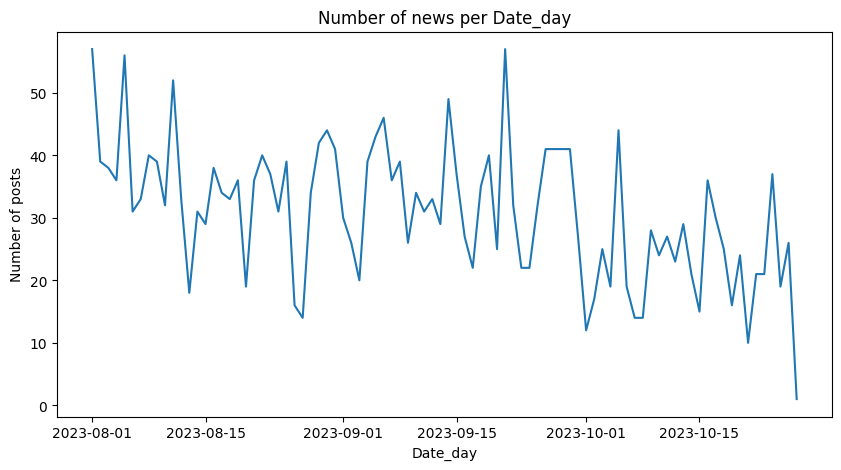

In [17]:
plt.figure(figsize=(10,5))
plt.title("Number of news per Date_day")
df.groupby("Date_day")["content"].count().plot()
plt.xlabel("Date_day")
plt.ylabel("Number of posts")
plt.show()

In [18]:
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
def read_txt_to_list(path):
    with open(path, 'r') as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

nltk.download("stopwords")

ru_stopwords = stopwords.words("russian")
# Taken from https://raw.githubusercontent.com/skupriienko/Ukrainian-Stopwords/master/stopwords_ua.txt 
ua_stopwords = read_txt_to_list("/kaggle/input/kyivchennels/stopwords_ua.txt")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
add_stopwords = [
    'instagram', 'facebook', 'telegram', 'tiktok', 'viber', 'live', 'livе', 'підписатися', 'приєднатися', 'підписатись',]

stopwords = list(set(
    ru_stopwords +
    ua_stopwords +
    add_stopwords
))

In [21]:
import re

def filter_stopwords(input):
    input = nltk.tokenize.word_tokenize(input)
    input = [word for word in input if word not in stopwords]
    return " ".join(input)

def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def process_text(input):
    if isinstance(input, str):
        link_pattern = r'(http\S+|www.\S+|(?:https?:\/\/)?(?:www\.)?(?:t\.me\/\S+|telegram\.me\/\S+|telegram\.dog\/\S+))'
        phone_pattern = r'\(?\+?\d{0,3}\)?[-.\s]?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{2}[-.\s]?\d{2}'

        # Compile regular expressions for better performance
        link_regex = re.compile(link_pattern)
        phone_regex = re.compile(phone_pattern)

        patterns = [
            link_regex,
            phone_regex,
            re.compile(r'[\n\t\r]'),
            re.compile(r'@\w+'),
        ]

        for pattern in patterns:
            input = pattern.sub('', input)

        emoji_pattern = re.compile(
            pattern="["
                    u"\U0001F600-\U0001F64F"  # emoticons
                    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                    u"\U0001F680-\U0001F6FF"  # transport & map symbols
                    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                    u"\U00002702-\U000027B0"
                    u"\U000024C2-\U0001F251"
                    u"\U0001f926-\U0001f937"
                    u'\U00010000-\U0010ffff'
                    u"\u200d"
                    u"\u2640-\u2642"
                    u"\u2600-\u2B55"
                    u"\u23cf"
                    u"\u23e9"
                    u"\u231a"
                    u"\u3030"
                    "]+", flags=re.UNICODE
        )
        input = emoji_pattern.sub(r'', input)

        input = re.sub(r' +', ' ', input)
        
        input = filter_stopwords(input)
        
        input = collapse_dots(input)
        
        
        
        input = input.strip()

    return input

df["content_processed"] = df["content"].apply(process_text)

<>:10: DeprecationWarning: invalid escape sequence '\.'
<>:10: DeprecationWarning: invalid escape sequence '\.'
/tmp/ipykernel_47/2761971999.py:10: DeprecationWarning: invalid escape sequence '\.'
  input = re.sub("\.+", ".", input)


In [30]:
df['content_processed'].sample(3).to_list()

["Київщина 85 % готова опалювального сезону , — КОВА1179 котелень підготовлено старту роботи . Об'єкти критичної інфраструктури соціального призначення забезпечують генераторами – 6 тис . Киев Сейчас",
 'Фоточки',
 "У Києві з'явитись сквер « Да Вінчі » , присвячений Дмитру Коцюбайлу.Іменем Героя України назвати зелену зону вулицею Михайла Омеляновича-Павленка Іподромним провулком Печерському районі . Невдовзі пропозицію винесуть громадське обговорення голосування містян . Киев Сейчас"]

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


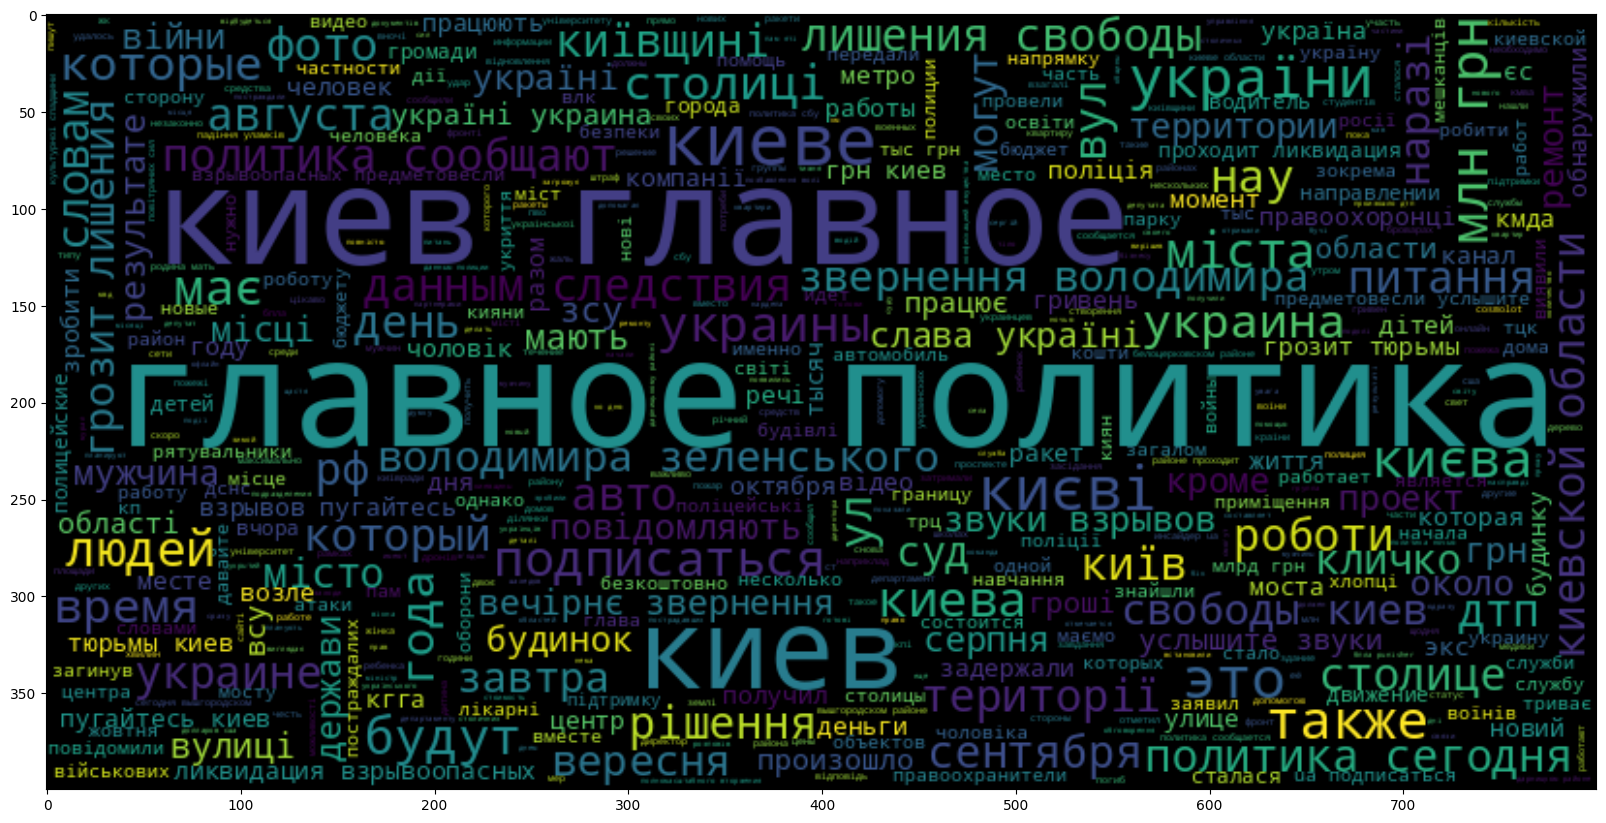

In [24]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(
    max_words = 500, 
    width = 800, 
    height = 400, 
    stopwords = ru_stopwords + ua_stopwords).generate(" ".join(df["content_processed"].apply(lambda x: x.lower())))
plt.imshow(wc, interpolation = 'bilinear')

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


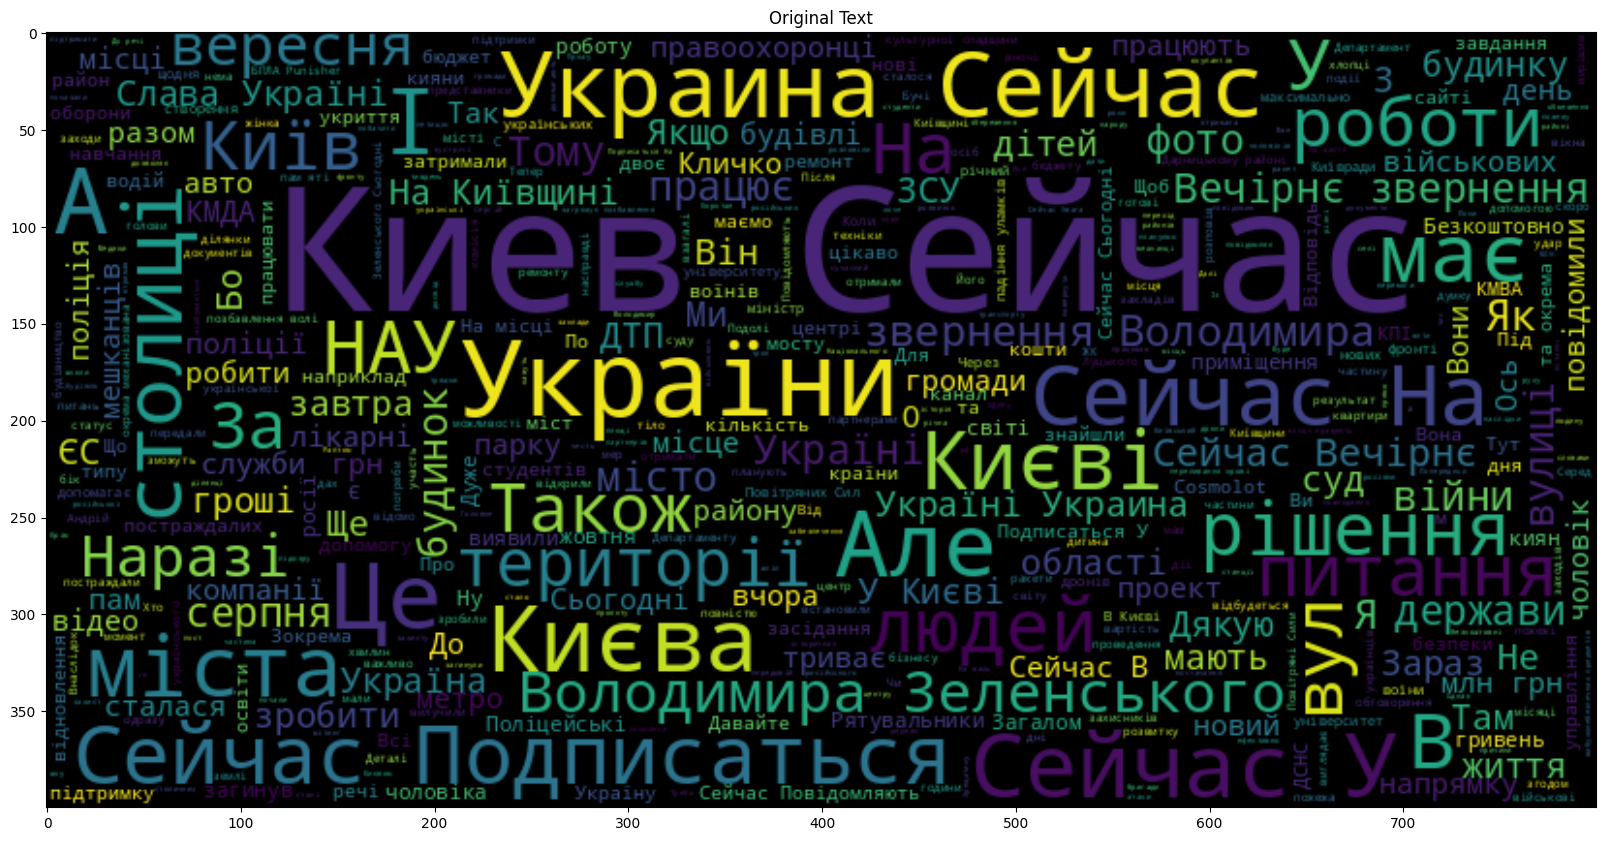

In [25]:
plt.figure(figsize=(20, 20))
plt.title("Original Text")
wc = WordCloud(max_words=500, width=800, height=400).generate(" ".join(df[df["lang"]=='uk']['content_processed']))
plt.imshow(wc, interpolation='bilinear')

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


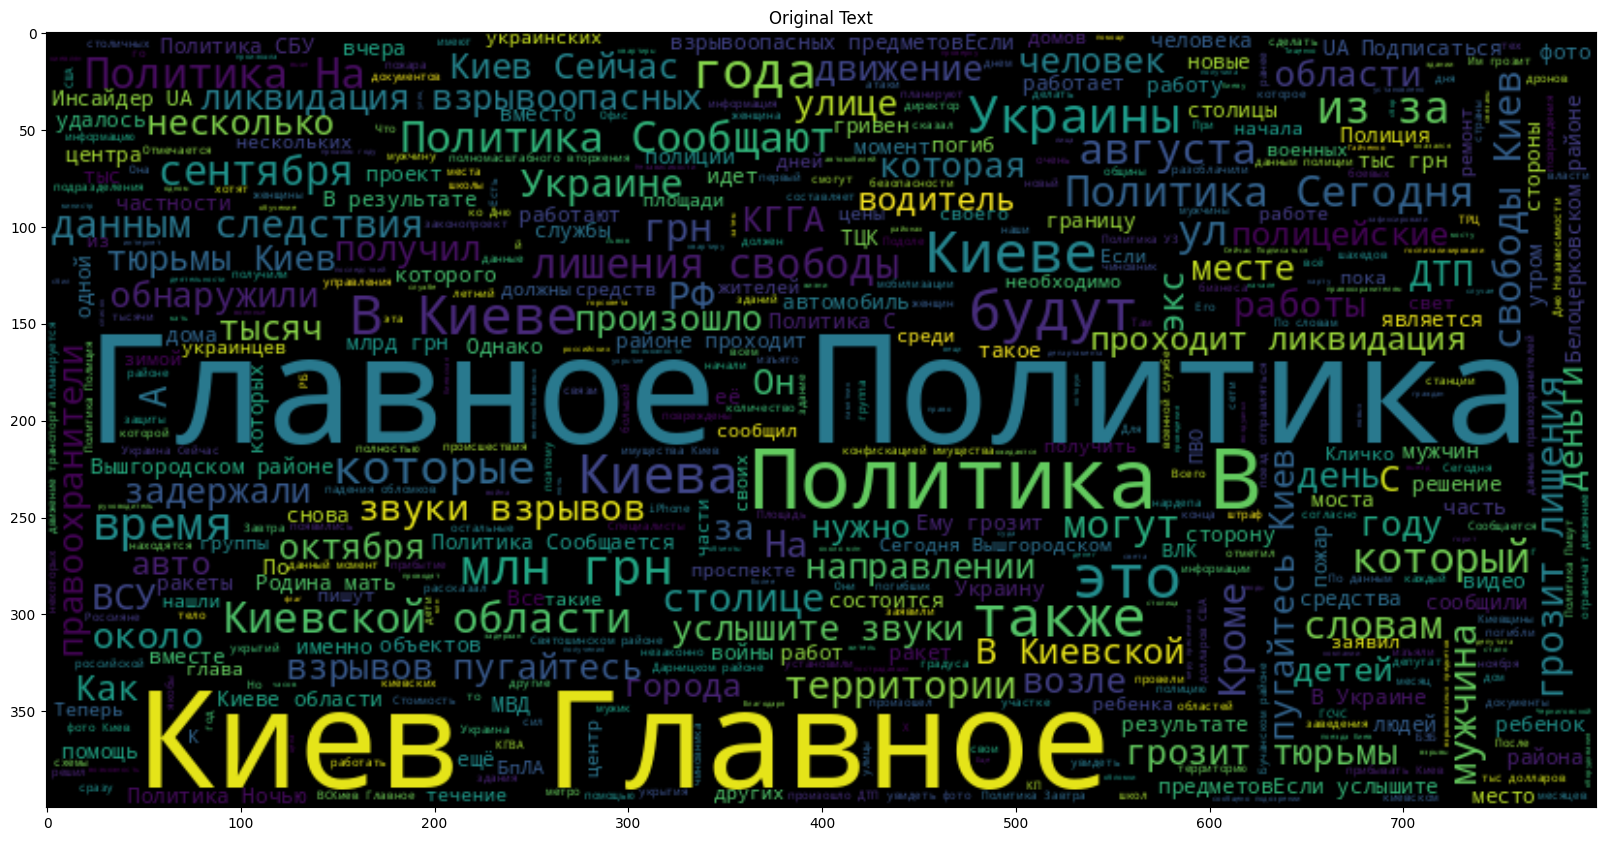

In [26]:
plt.figure(figsize=(20, 20))
plt.title("Original Text")
wc = WordCloud(max_words=500, width=800, height=400).generate(" ".join(df[df["lang"]=='ru']['content_processed']))
plt.imshow(wc, interpolation='bilinear')

## Extract Sentence embedding

In [27]:
# sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 - maps sentences & paragraphs to a 384 dimensional dense vector space
# sentence-transformers/distiluse-base-multilingual-cased-v2 - maps sentences & paragraphs to a 512 dimensional dense vector space
# sentence-transformers/paraphrase-multilingual-mpnet-base-v2 - maps sentences & paragraphs to a 768 dimensional dense vector space
# we'll stick with mpnet-base-v2 model

sent_emb_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

In [28]:
sent_embeddings = sent_emb_model.encode(df["content_processed"].to_list(), batch_size=100)

np.save(
    "KyivChannels_Dataset_v01_sent_embeddings.npy",
    sent_embeddings
)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

In [29]:
# sent_embeddings = np.load("/kaggle/input/kyivchennels/KyivChannels_Dataset_v01_sent_embeddings.npy")
assert sent_embeddings.shape[0] == df.shape[0]


# Clustering Algorithms

## Dimensionality Reduction

First of all let's explore and compare PCA, TSNE and UMAP methods for dimensionality reduction:

### PCA

In [31]:
from umap import UMAP
sent_pca = PCA().fit_transform(sent_embeddings)
sent_tsne = TSNE().fit_transform(sent_embeddings)
sent_umap = UMAP(n_neighbors=15).fit_transform(sent_embeddings)

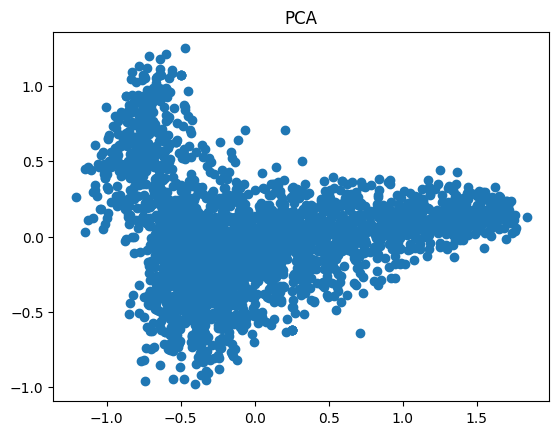

In [32]:
plt.title('PCA')
plt.scatter(sent_pca[:,0], sent_pca[:,1])

### TSNE

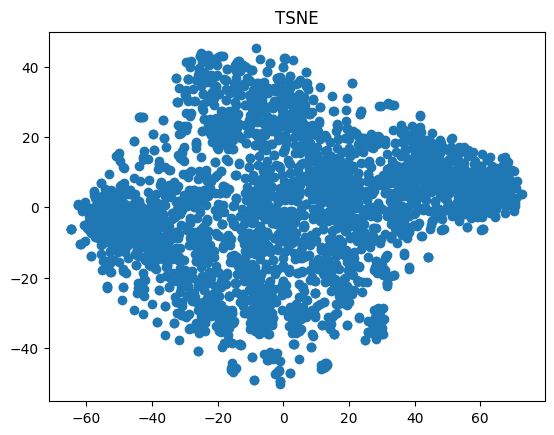

In [33]:
plt.title('TSNE')
plt.scatter(sent_tsne[:,0], sent_tsne[:,1])

### UMAP

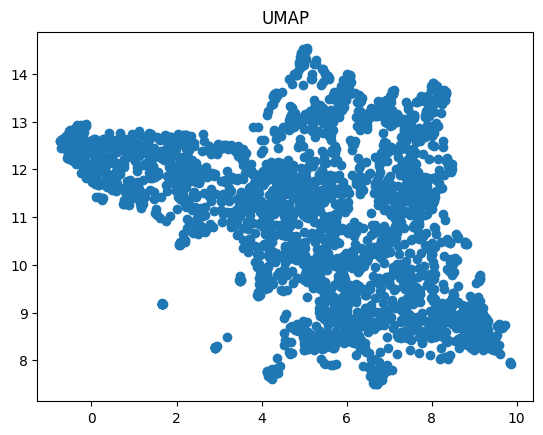

In [34]:
plt.title('UMAP')
plt.scatter(sent_umap[:,0], sent_umap[:,1])

TSNE looks kinda better(I mean we can some clusters of texts straightaway), but if we consider to use another set of channels like ['big_kyiv', 'kyivpolitics', 'darnicalive'] we may see that UMAP looks "better". This means that there is no universal dimensionality reduction technique, that will satisfy everyone.

Anyway, let's cluster our news with KMEANS, DBSCAN and HDBSCAN

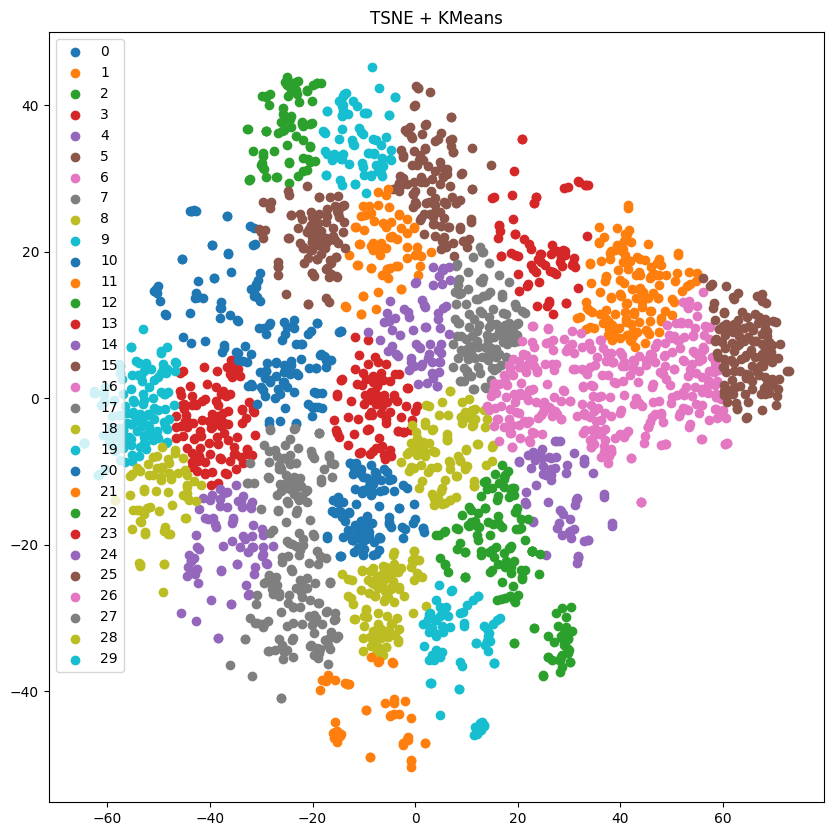

In [45]:
kmeans_clust = KMeans(
    n_clusters=30,
    random_state=42,
    init="k-means++"
).fit_predict(sent_tsne)

plt.figure(figsize=(10, 10))
plt.title("TSNE + KMeans")
for clust in np.unique(kmeans_clust):
    plt.scatter(
        sent_tsne[kmeans_clust == clust, 0],
        sent_tsne[kmeans_clust == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

This looks not really natural. It looks like KMEANS just divided the whole corpus into 30 "districts", so I'm not sure that texts in the clusters have anything in common

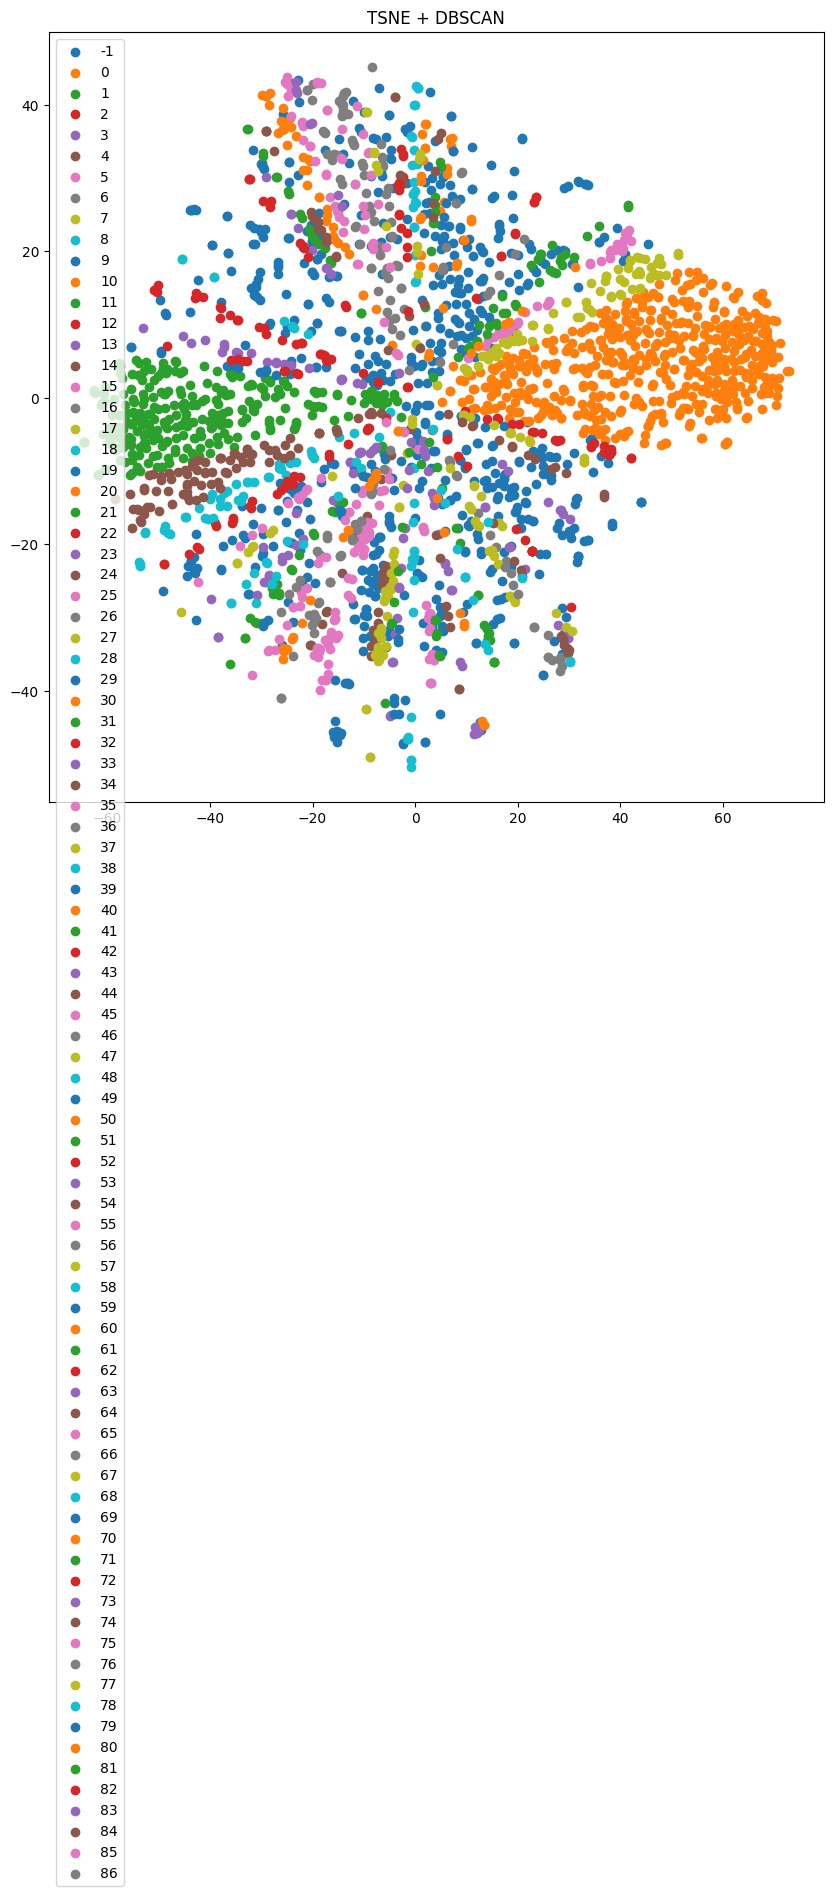

In [36]:
dbscan_clust = DBSCAN(
    eps=0.00003,
    min_samples=7,
    leaf_size=30,
    metric='cosine'
).fit_predict(sent_tsne)

plt.figure(figsize=(10, 10))
plt.title("TSNE + DBSCAN")
for clust in np.unique(dbscan_clust):
    plt.scatter(
        sent_tsne[dbscan_clust == clust, 0],
        sent_tsne[dbscan_clust == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

Not sure if it is supposed to look like this. 

In [37]:
df[dbscan_clust == 26]['content'].sample(3).to_list()

['Зловмисник підпалив 12 автівок військових у Києві.\n\nСерія підпалів сталася наприкінці 2022 року, всі авто були пошкоджені за допомогою саморобних приладів.\n\nЧоловіка викрили при спробі знищити 13-тий легковик. Свої дії затриманий пояснив негативним відношенням до військових. Йому загрожує до 10 років ув’язнення.\n\n🇺🇦 Киев Сейчас',
 'Появились видео, где Тищенко проникает в колл-центр с десятком крепких ребят \n\nНа видео с камер наблюдения попал момент штурма офиса. В соцсетях у нардепа картинка совершенно другая.\n\nКиев. Главное. Политика',
 'В Киеве будут судить мужчину, который развращал 2 15-летних парней \n\nПо данным полиции, педофил списывался со своими жертвами в интернете и назначал встречу у себя в квартире. Потом он совершал насилие над ними и давал "денежное вознаграждение". \n\nКроме того, при обыске были выявлены фото и видео с детской порнографией.\n\nПедофилу грозит до 8 лет тюрьмы.\n\n Киев. Главное. Политика']

Yeah, texts in this cluster have the same topic. That's something

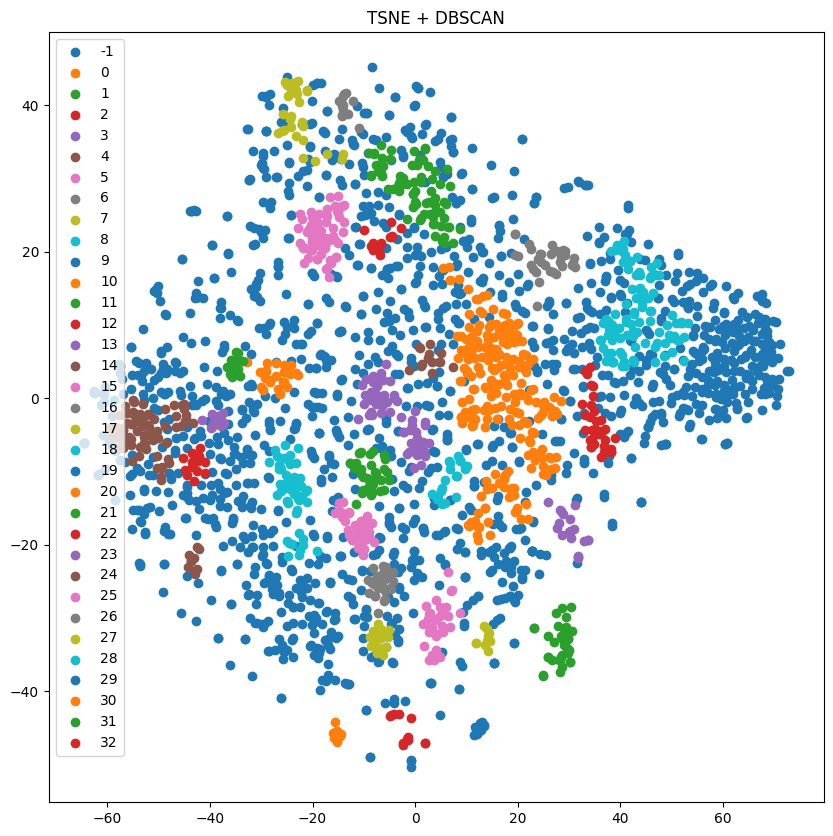

In [38]:
from hdbscan import HDBSCAN

hdbscan_clust = HDBSCAN(
    min_cluster_size=10,
    max_cluster_size=200,
).fit_predict(sent_tsne)

plt.figure(figsize=(10, 10))
plt.title("TSNE + DBSCAN")
for clust in np.unique(hdbscan_clust):
    plt.scatter(
        sent_tsne[hdbscan_clust == clust, 0],
        sent_tsne[hdbscan_clust == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

Oh! HDBSCAN looks great. Let's have a look at some examples of clustered texts

In [39]:
df[hdbscan_clust == 7]['content'].sample(5).to_list()

['У найближчу годину з утриманням до кінця доби 27 серпня прогнозують грози по Києву та області.\n\n🇺🇦 Киев Сейчас',
 '🌫️ Завтра у Києві та області очікується туман, - Укргідрометцентр\n\nЯк повідомляють синоптики, туман буде вночі та вранці, тому радимо бути більш обережними за кермом через погану видимість на дорозі.\n\n🇺🇦 Киев Сейчас',
 "Гідрослужби столиці готові до роботи під час прогнозованих дощів синоптиками\n\nНа фото — телефони гарячих ліній за різних ситуацій, пов'язаних з негодою.\n\n🇺🇦 Киев Сейчас",
 'Тим часом у деяких районах столиці почався дощ 🌧\n\nПопри те, що температура повітря зараз 28 градусів вище нуля.\n\n🇺🇦 Киев Сейчас',
 '🌧️ Сьогодні Київщину накриє негода, — Укргідрометцентр\n\nВ нашій області сьогодні переважатиме хмарна погода, а місцями будуть і дощі. Беріть парасолі! \n\n🇺🇦 Киев Сейчас']

Geat! HDBSCAN worked correctly.

<a id='Topic_Modelling'></a>
# Topic Modelling

## LDA Model

In [40]:
all_stopwords_puncts = set(stopwords) | set(string.punctuation)

In [61]:
index_without_duplicates = df.drop_duplicates("content_processed").index

index_without_duplicates.shape

(2689,)

In [66]:

random_ids = random.sample(range(len(index_without_duplicates)), 1000)
# random_ids = index_without_duplicates[random_ids].to_list()
np.save(
    "KyivChannels_Dataset_v01_random_ids.npy",
    np.array(random_ids)
)

In [67]:
docs = []
for d in tqdm(df.iloc[random_ids]['content_processed'].to_list()):
    docs.append(
        [el.lower() for el in tokenize.word_tokenize(d) if el.lower() not in all_stopwords_puncts]
    )

100%|██████████| 1000/1000 [00:00<00:00, 1299.47it/s]


In [68]:
# Create Dictionary
vocab = corpora.Dictionary(docs)
# doc2bow means Doc transformed to Bag of Words
corpus = [vocab.doc2bow(text) for text in docs]
# View
print(
    f"Text:\n{' '.join(docs[0])}\n\n"
    f"Text BOW:\n{corpus[0]}"
)

Text:
кпішники 16:00 виїзна нарада ремонту політехнічної підрядник роботам радий бачити студентів мають думки ремонту вулиці зустрічаємось кінці вулиці боку метро

Text BOW:
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1)]


In [69]:
# number of topics
num_topics = 40
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=vocab,
                                       num_topics=num_topics)
# Print the Keyword in the 40 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(6,
  '0.008*"главное" + 0.007*"политика" + 0.006*"киев" + 0.004*"‘" + 0.003*"``" '
  '+ 0.003*"\'\'" + 0.003*"8" + 0.003*"полномасштабного" + 0.003*"вторжения" + '
  '0.003*"районе"'),
 (15,
  '0.016*"главное" + 0.015*"политика" + 0.010*"киев" + 0.006*"\'\'" + '
  '0.004*"—" + 0.003*"«" + 0.003*"банку" + 0.003*"»" + 0.003*"–" + '
  '0.003*"тренировки"'),
 (32,
  '0.016*"\'\'" + 0.013*"``" + 0.012*"политика" + 0.010*"главное" + 0.004*"2" '
  '+ 0.004*"киеве" + 0.003*"будут" + 0.003*"свободы.киев" + 0.003*"грозит" + '
  '0.003*"завтра"'),
 (18,
  '0.013*"главное" + 0.013*"политика" + 0.012*"киев" + 0.006*"\'\'" + '
  '0.005*"``" + 0.004*"—" + 0.003*"млн" + 0.003*"границу" + 0.003*"досвідчені" '
  '+ 0.003*"12"'),
 (28,
  '0.014*"главное" + 0.014*"политика" + 0.008*"–" + 0.007*"\'\'" + '
  '0.006*"киев" + 0.004*"``" + 0.003*"»" + 0.003*"проект" + 0.003*"«" + '
  '0.003*"будинок"'),
 (0,
  '0.011*"главное" + 0.011*"политика" + 0.010*"киев" + 0.007*"—" + 0.006*"``" '
  '+ 0.006*"\'\'" + 0

### TSNE Clustering Chart

In [80]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w[1] for w in row_list])

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well-separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
n_topics = lda_model.num_topics
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

topic_num = np.clip(topic_num, 0, len(mycolors) - 1)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics),
              width=900, height=700)  # Use 'width' instead of 'plot_width'
plot.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 990 samples in 0.001s...
[t-SNE] Computed neighbors for 990 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 990 / 990
[t-SNE] Mean sigma: 0.000014
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.022675
[t-SNE] KL divergence after 1000 iterations: 0.117367


In [100]:
# Visualize the topics
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

dictionary=lda_model.id2word

In [ ]:
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=dictionary)

## BERTopic

In [107]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer

class PredsHDBSCANP(HDBSCAN):
    def predict(self, x):
        return self.fit_predict(x)

# Define parameters
embedding_model = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
language = "multilingual"
umap_params = {"n_neighbors": 15, "n_components": 10}
hdbscan_params = {"cluster_selection_epsilon": 0.3}
ctfidf_params = {"bm25_weighting": True}

# Create BERTopic instance
topic_model = BERTopic(
    embedding_model=embedding_model,
    language=language,
    umap_model=UMAP(**umap_params),
    hdbscan_model=PredsHDBSCANP(**hdbscan_params),
    ctfidf_model=ClassTfidfTransformer(**ctfidf_params),
    verbose=True,
)

In [108]:
topics, probs = topic_model.fit_transform(df.iloc[random_ids]['content_processed'].to_list())

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm im

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2023-11-13 08:17:50,772 - BERTopic - Transformed documents to Embeddings
2023-11-13 08:17:55,085 - BERTopic - Reduced dimensionality
2023-11-13 08:17:55,124 - BERTopic - Clustered reduced embeddings


In [109]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0      -1    302                  -1_политика_главное_00_сейчас   
1       0     86                   0_це_космолот_закиньте_бонус   
2       1     83                1_политика_главное_дтп_сообщают   
3       2     73              2_грозит_лишения_свободы_долларов   
4       3     58               3_район_режисер_политика_главное   
5       4     47                     4_00_проект_парку_сентября   
6       5     36            5_атаки_будинків_повреждены_уламків   
7       6     35       6_незалежності_сейчас_свято_непокоренный   
8       7     29                 7_дтп_водитель_результате_руху   
9       8     25               8_дітей_заведений_замінування_25   
10      9     21                        9_нау_це_тому_засідання   
11     10     21                      10_полиции_нашли_тіло_это   
12     11     15         11_звуки_ликвидация_услышите_пугайтесь   
13     12     15            12_вільного_світу_києва_ментального   
14     13     13      13_отбойкиев_кадры_красотакиев_нереальная   
15     14     11                    14_ракет_система_мая_ракета   
16     15     11                      15_негода_дощі_дощ_сейчас   
17     16     11               16_будут_линий_населения_пунктов   
18     17     11              17_суд_рішення_лісу_біличанському   
19     18      9                    18_водій_річний_помер_туман   
20     19      9               19_ветеранов_сбор_окрема_бригади   
21     20      9  20_оборонних_україни_університету_максимальне   
22     21      8             21_виноградарь_суд_установить_виде   
23     22      8                      22_30_тигриця_змея_горила   
24     23      8     23_сегодня_белоцерковском_услышите_взрывов   
25     24      7          24_температура_градуса_самой_градусов   
26     25      7                 25_00_кафе_ресторанов_приват24   
27     26      6     26_стеценко_сообщают_ретровиля_сбиваюткиев   
28     27      6                           27_поезд_05_львов_17   
29     28      5                28_серпня_00_движение_ограничат   
30     29      5                  29_услуг_женщины_видео_данным   
31     30      5      30_рятувальника_украина_україни_дистанцію   
32     31      5  31_африканской_карантин_території_недопущения   

                                       Representation  \
0   [политика, главное, 00, сейчас, грн, на, млн, ...   
1   [це, космолот, закиньте, бонус, але, давайте, ...   
2   [политика, главное, дтп, сообщают, улицы, дтпк...   
3   [грозит, лишения, свободы, долларов, сбу, заде...   
4   [район, режисер, политика, главное, миг, облас...   
5   [00, проект, парку, сентября, sport, park, iph...   
6   [атаки, будинків, повреждены, уламків, сейчас,...   
7   [незалежності, сейчас, свято, непокоренный, ки...   
8   [дтп, водитель, результате, руху, произошло, в...   
9   [дітей, заведений, замінування, 25, школ, осві...   
10  [нау, це, тому, засідання, банку, рішення, рео...   
11  [полиции, нашли, тіло, это, возле, полиция, да...   
12  [звуки, ликвидация, услышите, пугайтесь, взрыв...   
13  [вільного, світу, києва, ментального, здоровье...   
14  [отбойкиев, кадры, красотакиев, нереальная, бю...   
15  [ракет, система, мая, ракета, рб, силы, ракети...   
16  [негода, дощі, дощ, сейчас, київщину, сьогодні...   
17  [будут, линий, населения, пунктов, тарифы, сез...   
18  [суд, рішення, лісу, біличанському, верховного...   
19  [водій, річний, помер, туман, автомобиля, дтп,...   
20  [ветеранов, сбор, окрема, бригади, хлопці, зав...   
21  [оборонних, україни, університету, максимальне...   
22  [виноградарь, суд, установить, виде, обыски, с...   
23  [30, тигриця, змея, горила, тоні, 407, отпечат...   
24  [сегодня, белоцерковском, услышите, взрывов, п...   
25  [температура, градуса, самой, градусов, предыд...   
26  [00, кафе, ресторанов, приват24, работе, терми...   
27  [стеценко, сообщают, ретровиля, сбиваюткиев, т...   
28  [поезд, 05, львов, 17, прибытие, поезда, 27, х...   
29  [серпня, 00

In [110]:
topic_model.get_topic(6)

[('незалежності', 0.04050491129740458),
 ('сейчас', 0.039184029255303704),
 ('свято', 0.03596291293597105),
 ('непокоренный', 0.030417671947281948),
 ('киеве', 0.02993514807380592),
 ('мариуполь', 0.029018890342750004),
 ('батьківщина', 0.026972184701978288),
 ('мати', 0.026972184701978288),
 ('людей', 0.02473776943731293),
 ('україни', 0.02276175475866384)]

In [111]:
topic_model.visualize_topics()

In [129]:
import numpy as np
import random

def predict_topic_names(topic_model, corpus, n_documents=None, n_top_topics=None):
    if n_documents is None:
        n_documents = len(corpus)

    corpus = np.array(corpus)
    
    checked_doc_ids = random.sample(range(len(corpus)), min(len(corpus), n_documents))
    
    topic_ids, _ = topic_model.fit_transform(corpus)
    
    unique_topic_ids, id_counts = np.unique(topic_ids, return_counts=True)

    sorted_topic_ids = list(reversed(unique_topic_ids[np.argsort(id_counts)]))

    if n_top_topics is not None:
        sorted_topic_ids = sorted_topic_ids[:n_top_topics]
    
    topic_names = []
    for topic_id in sorted_topic_ids:
        topic_names.append(topic_model.get_topic_info(topic_id)['Name'].iloc[0])
        
    return topic_names

def predict_topics_for_channels(channels, dataset, topic_model, n_documents=500, n_top_topics=5):
    # Initialize a dictionary to store topics for each channel
    channel_topics = {}
    
    # Iterate through each channel
    for channel in channels:
        # Extract documents for the current channel from the dataset
        channel_docs = dataset[dataset['channelname'] == channel]['content_processed'].to_list()
        
        # Predict topics for the channel's documents
        channel_topics[channel] = predict_topic_names(topic_model, channel_docs, n_documents, n_top_topics)
    
    # Return the dictionary containing topics for each channel
    return channel_topics


In [131]:
# Predicting topics for the daset of 3 selected channels
channels = list(set(selected_channels))
channel_topics = predict_topics_for_channels(channels, df, topic_model)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm im

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

2023-11-13 08:47:33,319 - BERTopic - Transformed documents to Embeddings
2023-11-13 08:47:40,318 - BERTopic - Reduced dimensionality
2023-11-13 08:47:40,375 - BERTopic - Clustered reduced embeddings
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packa

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

2023-11-13 08:48:09,929 - BERTopic - Transformed documents to Embeddings
2023-11-13 08:48:13,135 - BERTopic - Reduced dimensionality
2023-11-13 08:48:13,156 - BERTopic - Clustered reduced embeddings
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.

/opt/conda/lib/python3.10/site-packa

Batches:   0%|          | 0/26 [00:00<?, ?it/s]

2023-11-13 08:49:09,895 - BERTopic - Transformed documents to Embeddings
2023-11-13 08:49:13,712 - BERTopic - Reduced dimensionality
2023-11-13 08:49:13,745 - BERTopic - Clustered reduced embeddings


In [132]:
channel_topics

{'kyivpolitics': ['0_главное_политика_киев_киеве',
  '1_чрезвычайный_опасностикиев_пожарной_уровень'],
 'semenovatut': ['-1_але_парку_це_місто',
  '0_обіцяла_як_результатами_вибачте',
  '1_фролов_корупціонерами_чим_ти',
  '2_бюджет_гроші_бюджету_мільярди',
  '3_нау_реорганізації_освіти_університету'],
 'kyiv_n': ['-1_на_районі_київщині_території',
  '0_вул_окрема_україни_бригада',
  '1_батьківщина_мати_незалежності_матері',
  '2_україни_україні_слава_подписаться',
  '3_тіло_дитина_річний_річну']}

In [ ]:
# Now we need the whole news dataset

DF = pd.read_csv(/kaggle/input/kyivchennels/KyivChannels_Dataset_v01.csv)
DF["content_processed"] = DF["content"].apply(process_text)

# Predicting topics for the first 6 channels in the whole dataset
whole_channels = list(set(dataset['channelname']))[:6]
whol_channel_topics = predict_topics_for_channels(whole_channels, DF, topic_model)